In [31]:
%reload_ext autoreload
%autoreload 2

import random
import torch

random.seed(42)
torch.manual_seed(42)


In [32]:
from learning.gpt2.model import GPT2, PretrainedName


device = torch.device("cuda")
model, _pretrained_model = GPT2.from_pretrained(
    PretrainedName.GPT2_SMALL, device=device
)


In [33]:
from data.names_data_source import NamesDataSource
from learning.gpt2.ioi_circuit_analyzer import NameSampler, PromptTemplate
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")


names_data_source = NamesDataSource.load(
    data_folder="../datasets/names",
)

# Get all English names
all_english_names = names_data_source.country_idx_to_names[4]


def filter_single_token_names(names: list[str]) -> list[str]:
    all_indices = tokenizer.encode_batch(names)
    single_token_indices = [indices for indices in all_indices if len(indices) == 1]
    return tokenizer.decode_batch(single_token_indices)


# Keep only the names that are single tokens (without space padding). E.g. "John"
filtered_names = filter_single_token_names(all_english_names)

# Add space padding to the names, and filter again
padded_filtered_names = [" " + name for name in filtered_names]
single_token_names = filter_single_token_names(padded_filtered_names)
single_token_names = [name[1:] for name in single_token_names]

# The final names are guaranteed to be single tokens, with or without space padding. E.g. " John" and "John"
print(len(single_token_names))
print(single_token_names)

name_sampler = NameSampler(single_token_names)
prompt_template = PromptTemplate(
    template="When {s1} and {s2} went to the store, {s3} gave a drink to",
    name_sampler=name_sampler,
)

print("-" * 80)
for _ in range(10):
    print(prompt_template.sample_abc())

print("-" * 80)
for _ in range(10):
    print(prompt_template.sample_aba())

print("-" * 80)
for _ in range(10):
    print(prompt_template.sample_abb())


254
['Adam', 'Adams', 'Albert', 'Alexander', 'Ali', 'Allen', 'Anderson', 'Andrew', 'Anthony', 'Arthur', 'Austin', 'Ball', 'Bear', 'Beck', 'Beer', 'Bell', 'Berry', 'Best', 'Bill', 'Bird', 'Black', 'Blake', 'Bloom', 'Bob', 'Bone', 'Brain', 'Bright', 'Brook', 'Brown', 'Bruce', 'Bull', 'Burn', 'Bush', 'Button', 'Carter', 'Chan', 'Chance', 'Charge', 'Charles', 'Child', 'Church', 'Clark', 'Close', 'Cole', 'Coll', 'Collins', 'Connor', 'Cook', 'Core', 'Court', 'Craig', 'Crew', 'Cross', 'Dallas', 'Daniel', 'David', 'Davis', 'Day', 'Dean', 'Diamond', 'Dick', 'Donald', 'Down', 'Driver', 'East', 'Edge', 'England', 'English', 'Fall', 'Field', 'Fish', 'Ford', 'Fox', 'Frame', 'France', 'French', 'Friend', 'Gall', 'Gene', 'George', 'Given', 'Glass', 'Gold', 'Good', 'Gordon', 'Graham', 'Grant', 'Gray', 'Green', 'Grey', 'Guest', 'Hall', 'Hamilton', 'Hand', 'Harris', 'Harry', 'Hart', 'Head', 'Henry', 'Hill', 'Hope', 'Houston', 'Howard', 'Hunt', 'Hunter', 'Ireland', 'Islam', 'Jackson', 'Jacob', 'James', '

In [34]:
from learning.gpt2.ioi_circuit_analyzer import IoiCircuitAnalyzer

analyzer = IoiCircuitAnalyzer(model, tokenizer, prompt_template, device)


def run_case(analyzer: IoiCircuitAnalyzer, model: GPT2, case: str, k: int):
    print(case)
    result = analyzer.topk_probs(case, k)
    for i in range(k):
        indices = [int(result.top_indices[i])]
        print(f"{result.top_probs[i]:.2f} {tokenizer.decode(indices)}")


def run_test(analyzer: IoiCircuitAnalyzer, model: GPT2):
    k = 3
    templates: list[PromptTemplate] = [
        PromptTemplate(
            template="When {s1} and {s2} went to the store, {s3} gave a drink to",
            name_sampler=name_sampler,
        ),
        PromptTemplate(
            template="When {s1} and {s2} went to the park, {s3} gave a leaf to",
            name_sampler=name_sampler,
        ),
        PromptTemplate(
            template="Yesterday {s1} and {s2} went to the store. {s3} gave a drink to",
            name_sampler=name_sampler,
        ),
    ]

    print("ABC " + "-" * 80)
    for template in templates:
        for _ in range(3):
            run_case(analyzer, model, template.sample_abc(), k)

    print("ABA " + "-" * 80)
    for template in templates:
        for _ in range(3):
            run_case(analyzer, model, template.sample_aba(), k)

    print("ABB " + "-" * 80)
    for template in templates:
        for _ in range(3):
            run_case(analyzer, model, template.sample_abb(), k)


run_test(analyzer, model)

ABC --------------------------------------------------------------------------------
When Mac and French went to the store, Stack gave a drink to
0.19  the
0.10  them
0.06  a
When Pack and Number went to the store, Thom gave a drink to
0.16  the
0.08  a
0.07  his
When Strong and Hamilton went to the store, Michael gave a drink to
0.16  the
0.08  a
0.07  them
When Court and Reader went to the park, Best gave a leaf to
0.30  the
0.05  a
0.04  Judge
When Ball and Pierre went to the park, Dean gave a leaf to
0.13  the
0.07  Pierre
0.06  them
When Said and France went to the park, York gave a leaf to
0.26  the
0.06  his
0.05  a
Yesterday Black and Strange went to the store. Diamond gave a drink to
0.20  the
0.08  me
0.08  them
Yesterday Sullivan and Brain went to the store. Head gave a drink to
0.16  the
0.10  Sullivan
0.09  them
Yesterday Ford and Judge went to the store. Park gave a drink to
0.22  the
0.13  them
0.09  Judge
ABA -------------------------------------------------------------

In [35]:
print(model.config)
print(model)

ModelConfig(embedding_size=768, num_heads=12, num_blocks=12, vocab_size=50257, sequence_length=1024, feed_forward_expansion_factor=4, dropout=0.1, device=device(type='cuda'))
GPT2(
  (embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks_module): ModuleList(
    (0-11): 12 x Block(
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (heads_module): ModuleList(
          (0-11): 12 x AttentionHead(
            (query): Linear(in_features=768, out_features=64, bias=True)
            (key): Linear(in_features=768, out_features=64, bias=True)
            (value): Linear(in_features=768, out_features=64, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm2): Laye

In [36]:
from learning.gpt2.ioi_circuit_analyzer import HeadAnalysisResult

batch_size = 2**7
prompts_abc = prompt_template.sample_batch_abc(batch_size)
baseline_output = analyzer.capture_baseline_output(prompts_abc)


results = []
for head_idx in range(model.config.num_heads):
    result: HeadAnalysisResult = analyzer.analyze_head_v2(
        baseline_output,
        11,
        head_idx,
        "Mary",
        "John",
    )
    results.append(result)
    print("-" * 80)
    print(f"{head_idx=}")
    print(
        result.original_probs[result.s1_indices].item(),
        result.patched_probs[result.s1_indices].item(),
    )
    print(
        result.original_probs[result.s2_indices].item(),
        result.patched_probs[result.s2_indices].item(),
    )

--------------------------------------------------------------------------------
head_idx=0
0.44601815938949585 0.4544221758842468
0.05997547134757042 0.0629577711224556
--------------------------------------------------------------------------------
head_idx=1
0.44601815938949585 0.2991105914115906
0.05997547134757042 0.027607636526226997
--------------------------------------------------------------------------------
head_idx=2
0.44601815938949585 0.32049551606178284
0.05997547134757042 0.06217831000685692
--------------------------------------------------------------------------------
head_idx=3
0.44601815938949585 0.3564991056919098
0.05997547134757042 0.06863654404878616
--------------------------------------------------------------------------------
head_idx=4
0.44601815938949585 0.44939103722572327
0.05997547134757042 0.05974232405424118
--------------------------------------------------------------------------------
head_idx=5
0.44601815938949585 0.448503315448761
0.05997547134

In [37]:
results = []
s1, s2 = name_sampler.sample(2)
for head_idx in range(model.config.num_heads):
    result: HeadAnalysisResult = analyzer.analyze_head_v2(
        baseline_output,
        11,
        head_idx,
        s1,
        s2,
    )
    results.append(result)
    print("-" * 80)
    print(f"{head_idx=}")
    print(
        result.original_probs[result.s1_indices].item(),
        result.patched_probs[result.s1_indices].item(),
    )
    print(
        result.original_probs[result.s2_indices].item(),
        result.patched_probs[result.s2_indices].item(),
    )


--------------------------------------------------------------------------------
head_idx=0
0.07860320061445236 0.08226029574871063
0.0209151953458786 0.020015614107251167
--------------------------------------------------------------------------------
head_idx=1
0.07860320061445236 0.04125222936272621
0.0209151953458786 0.020670728757977486
--------------------------------------------------------------------------------
head_idx=2
0.07860320061445236 0.06679724156856537
0.0209151953458786 0.012581508606672287
--------------------------------------------------------------------------------
head_idx=3
0.07860320061445236 0.04376405477523804
0.0209151953458786 0.01738716848194599
--------------------------------------------------------------------------------
head_idx=4
0.07860320061445236 0.08181137591600418
0.0209151953458786 0.022643961012363434
--------------------------------------------------------------------------------
head_idx=5
0.07860320061445236 0.061051178723573685
0.020915

In [38]:
from learning.gpt2.ioi_circuit_analyzer import (
    HeadId,
    PathPatchingConfig,
)
from learning.gpt2.metrics import DiffLogitsMetrics

print(prompt_template.template)

results: list[DiffLogitsMetrics] = []
for head_idx in range(model.config.num_heads):
    print("-" * 80)
    print(f"{head_idx=}")
    metrics: DiffLogitsMetrics = analyzer.analyze_head_pairwise(
        PathPatchingConfig(
            batch_size=1,
            start_head=HeadId(block_idx=11, head_idx=head_idx),
            end_heads=[],
        )
    )
    results.append(metrics)

df = DiffLogitsMetrics.merge_df(results)
print("\n" + "=" * 80)
print("SUMMARY: Most impactful heads (by L1 norm)")
print("=" * 80)
print(df.sort_values(by="s1_prob", ascending=False))

When {s1} and {s2} went to the store, {s3} gave a drink to
--------------------------------------------------------------------------------
head_idx=0
prompt_abc='When Mary and John went to the store, Jerry gave a drink to'
0.3058  them
0.1539  Mary
0.1105  the
prompt_aba='When Mary and John went to the store, Mary gave a drink to'
0.3024  John
0.2392  them
0.1294  the
prompt_aba='When Mary and John went to the store, Mary gave a drink to'
0.2966  John
0.2366  them
0.1365  the
--------------------------------------------------------------------------------
head_idx=1
prompt_abc='When Mary and John went to the store, Jerry gave a drink to'
0.3058  them
0.1539  Mary
0.1105  the
prompt_aba='When Mary and John went to the store, Mary gave a drink to'
0.3024  John
0.2392  them
0.1294  the
prompt_aba='When Mary and John went to the store, Mary gave a drink to'
0.2990  John
0.2446  them
0.1282  the
--------------------------------------------------------------------------------
head_idx=2
pro

In [39]:
from learning.gpt2.metrics import ProbsMetrics

BATCH_SIZE = 2**5

baseline_output = analyzer.capture_baseline_output(
    prompt_template.sample_batch_abc(128)
)

results: list[DiffLogitsMetrics] = []
for head_idx in range(model.config.num_heads):
    metrics = analyzer.analyze_head(
        PathPatchingConfig(
            batch_size=1,
            start_head=HeadId(block_idx=11, head_idx=head_idx),
            end_heads=[],
        ),
        baseline_output,
    )
    results.append(metrics)

print(prompt_template.template)

print("\n" + "=" * 80)
print("SUMMARY: Most impactful heads (by KL divergence)")
print("=" * 80)
df = DiffLogitsMetrics.merge_df(results)
print(df.sort_values(by="s1_prob", ascending=False))


When {s1} and {s2} went to the store, {s3} gave a drink to

SUMMARY: Most impactful heads (by KL divergence)
    s1_logit  s2_logit   s1_prob   s2_prob
10  0.399475  0.532387  0.112281  0.010821
6  -0.843376 -1.547066  0.021090 -0.079629
4   0.207428  0.166527  0.006051  0.002375
7  -0.286819 -0.331856  0.005386 -0.001106
0   0.044510  0.103394 -0.000018  0.000538
5  -0.252098 -0.182343 -0.000317  0.001126
9  -0.718933 -0.555298 -0.010302 -0.000479
8   0.509766  0.567192 -0.013697  0.000751
11 -0.119263 -0.156158 -0.016617 -0.000124
1  -0.667221 -0.642731 -0.021047 -0.001221
2  -0.760941 -1.250763 -0.067843 -0.021877
3  -0.473793 -0.308540 -0.071629  0.000805


AttributeError: 'DiffLogitsMetrics' object has no attribute 'metrics'

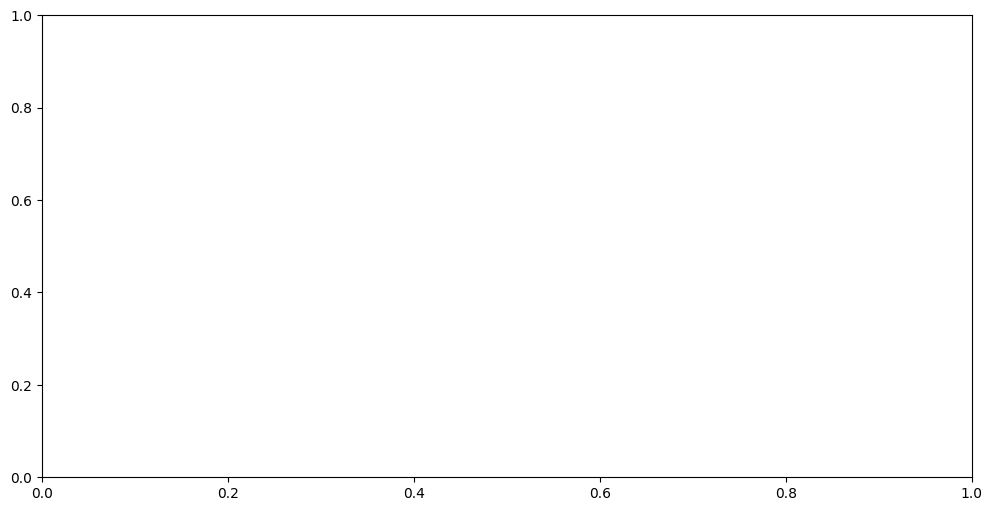

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create a bar plot of KL divergence for all heads
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

head_indices = list(range(len(results)))
kl_divergences = [result.metrics.kl_divergence for result in results]

bars = ax.bar(
    head_indices, kl_divergences, alpha=0.7, color="skyblue", edgecolor="navy"
)
ax.set_xlabel("Head Index")
ax.set_ylabel("KL Divergence")
ax.set_title(
    'KL Divergence by Head (Layer 11)\nPrompt: "When Mary and John went to the store, John gave a drink to"'
)
ax.set_xticks(head_indices)
ax.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, (bar, kl) in enumerate(zip(bars, kl_divergences)):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.001,
        f"{kl:.4f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

print(f"Total heads analyzed: {len(results)}")
print(
    f"Max KL divergence: {max(kl_divergences):.4f} (Head {kl_divergences.index(max(kl_divergences))})"
)
print(
    f"Min KL divergence: {min(kl_divergences):.4f} (Head {kl_divergences.index(min(kl_divergences))})"
)


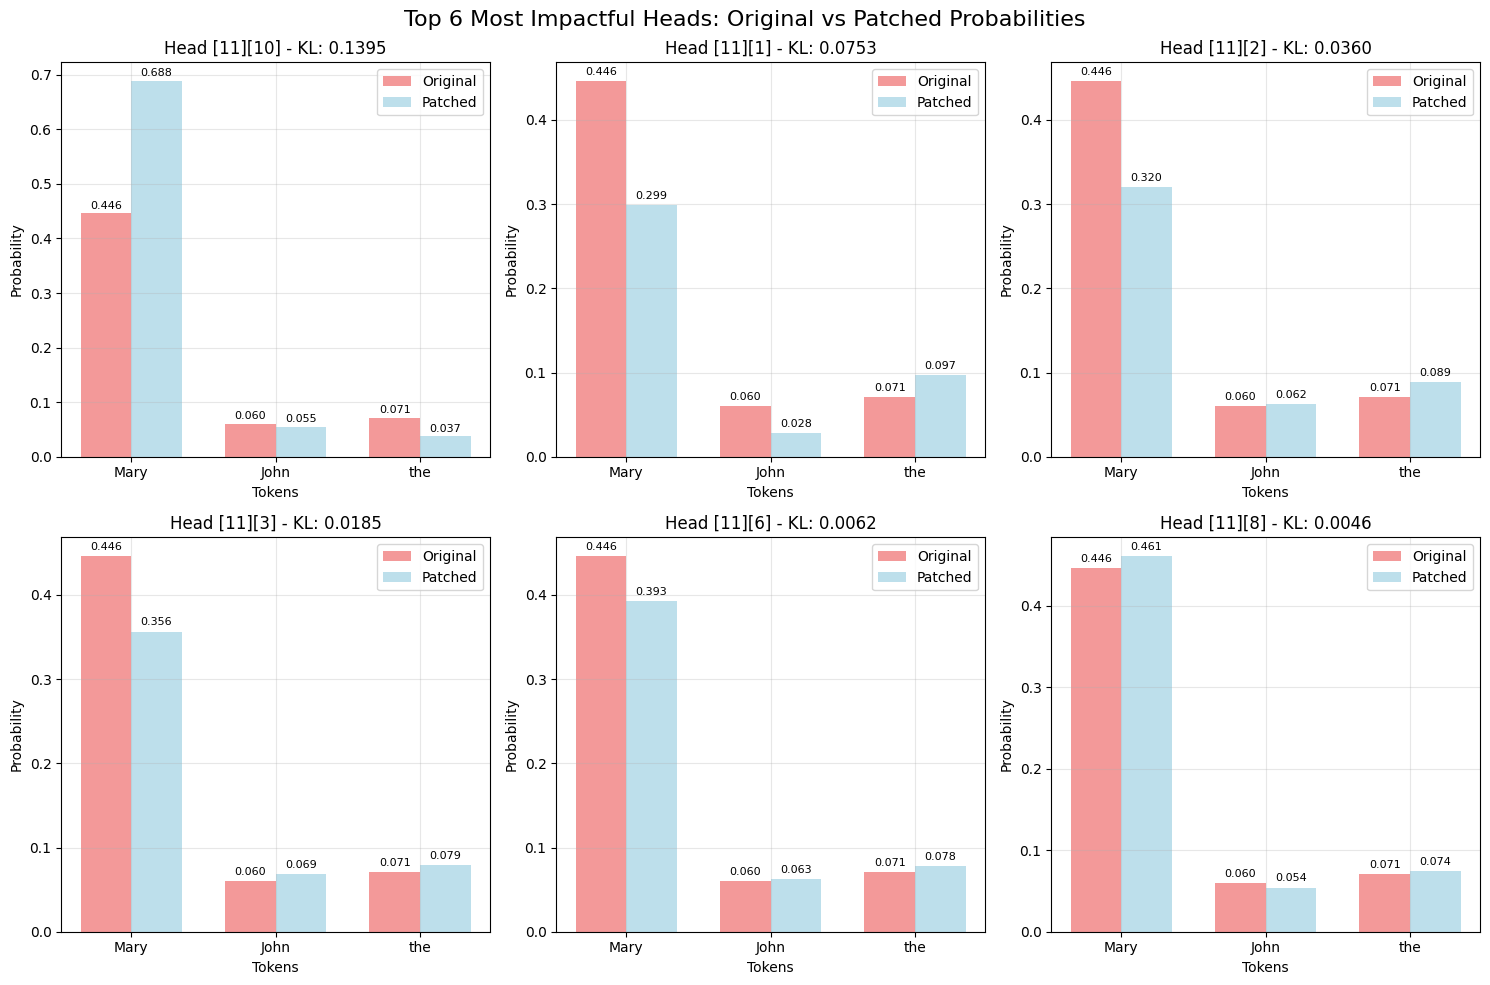

In [51]:
# Create individual plots for the top 6 most impactful heads
sorted_results = sorted(
    enumerate(results), key=lambda x: x[1].metrics.kl_divergence, reverse=True
)
top_heads = sorted_results[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (head_idx, result) in enumerate(top_heads):
    ax = axes[i]

    # Create a comparison of original vs patched probabilities for key tokens
    # Get the indices for Mary and John (with space padding)
    mary_idx = tokenizer.encode(" Mary")[0]
    john_idx = tokenizer.encode(" John")[0]
    the_idx = tokenizer.encode(" the")[0]

    # Extract probabilities for these key tokens
    orig_probs = result.original_probs.squeeze().cpu()
    patch_probs = result.patched_probs.squeeze().cpu()

    tokens = ["Mary", "John", "the"]
    token_indices = [mary_idx, john_idx, the_idx]
    original_vals = [orig_probs[idx].item() for idx in token_indices]
    patched_vals = [patch_probs[idx].item() for idx in token_indices]

    x = np.arange(len(tokens))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2,
        original_vals,
        width,
        label="Original",
        alpha=0.8,
        color="lightcoral",
    )
    bars2 = ax.bar(
        x + width / 2,
        patched_vals,
        width,
        label="Patched",
        alpha=0.8,
        color="lightblue",
    )

    ax.set_xlabel("Tokens")
    ax.set_ylabel("Probability")
    ax.set_title(f"Head [11][{head_idx}] - KL: {result.metrics.kl_divergence:.4f}")
    ax.set_xticks(x)
    ax.set_xticklabels(tokens)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, val in zip(bars1, original_vals):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    for bar, val in zip(bars2, patched_vals):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.suptitle(
    "Top 6 Most Impactful Heads: Original vs Patched Probabilities", fontsize=16
)
plt.tight_layout()
plt.show()


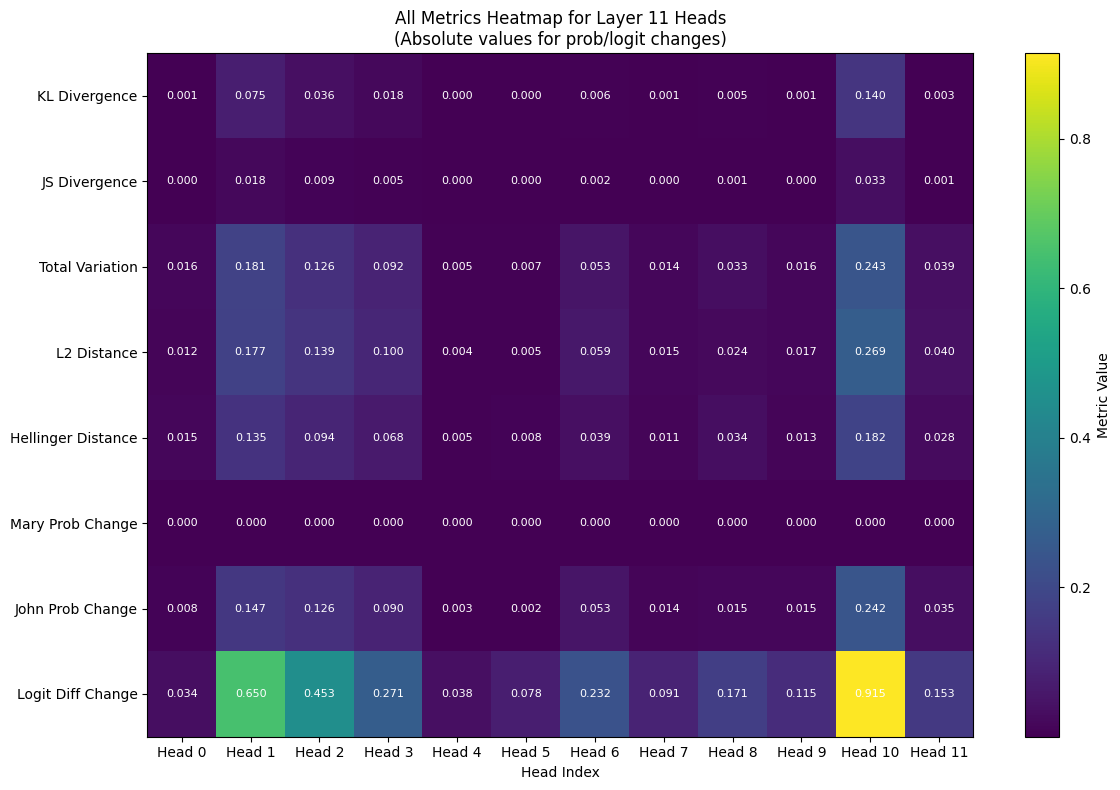

In [52]:
# Create a heatmap showing all metrics for each head
metrics_data = []
metric_names = [
    "KL Divergence",
    "JS Divergence",
    "Total Variation",
    "L2 Distance",
    "Hellinger Distance",
    "Mary Prob Change",
    "John Prob Change",
    "Logit Diff Change",
]

for result in results:
    metrics_data.append(
        [
            result.metrics.kl_divergence,
            result.metrics.js_divergence,
            result.metrics.total_variation,
            result.metrics.l2_distance,
            result.metrics.hellinger_distance,
            abs(
                result.metrics.s1_prob_change
            ),  # Use absolute value for better visualization
            abs(result.metrics.s2_prob_change),
            abs(result.metrics.logit_diff_change),
        ]
    )

metrics_array = np.array(metrics_data)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
im = ax.imshow(metrics_array.T, cmap="viridis", aspect="auto")

# Set ticks and labels
ax.set_xticks(range(len(results)))
ax.set_xticklabels([f"Head {i}" for i in range(len(results))])
ax.set_yticks(range(len(metric_names)))
ax.set_yticklabels(metric_names)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Metric Value")

# Add text annotations
for i in range(len(results)):
    for j in range(len(metric_names)):
        text = ax.text(
            i,
            j,
            f"{metrics_array[i, j]:.3f}",
            ha="center",
            va="center",
            color="white",
            fontsize=8,
        )

ax.set_title(
    "All Metrics Heatmap for Layer 11 Heads\n(Absolute values for prob/logit changes)"
)
ax.set_xlabel("Head Index")
plt.tight_layout()
plt.show()


=== DETAILED ANALYSIS: Head [11][1] ===
KL Divergence: 0.075303
Mary probability change: -0.000000
John probability change: 0.146908
Logit difference change: -0.649918


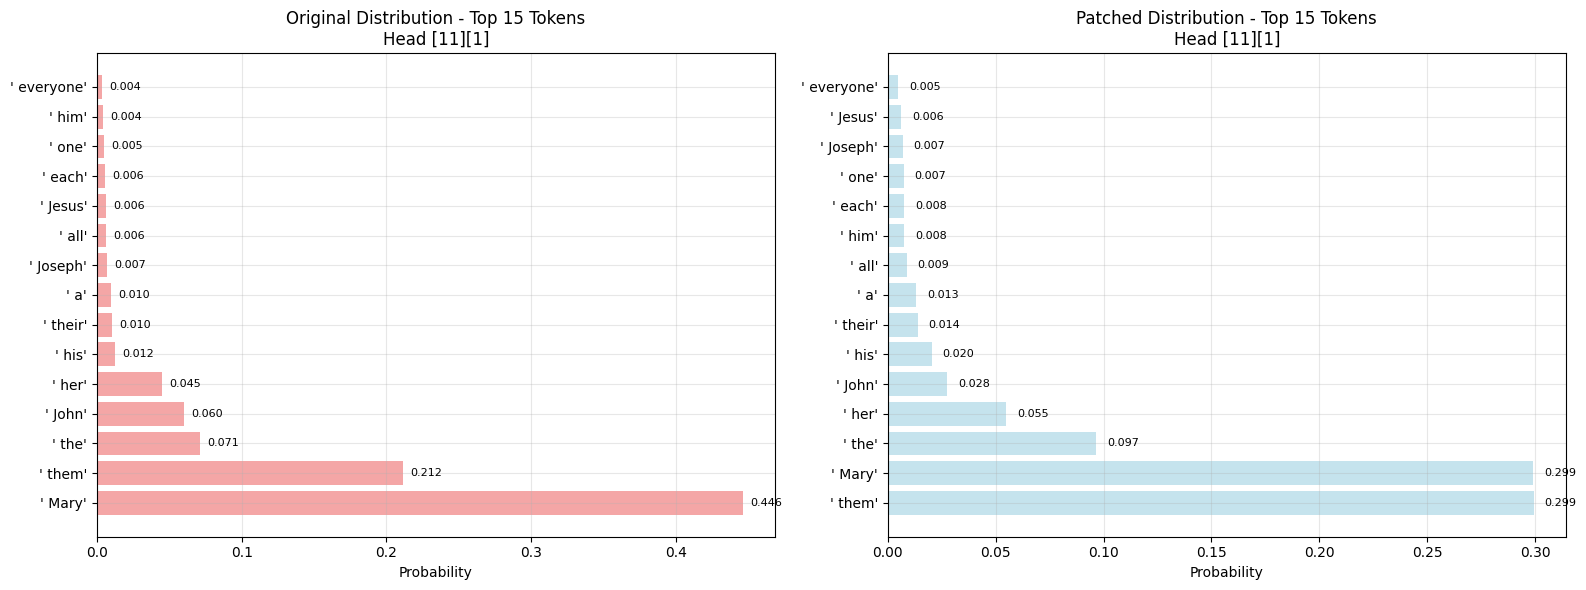

In [53]:
# Focus on the most impactful head (Head 1) - detailed analysis
most_impactful_head_idx = 1
most_impactful_result = results[most_impactful_head_idx]

print(f"=== DETAILED ANALYSIS: Head [11][{most_impactful_head_idx}] ===")
print(f"KL Divergence: {most_impactful_result.metrics.kl_divergence:.6f}")
print(f"Mary probability change: {most_impactful_result.metrics.s1_prob_change:.6f}")
print(f"John probability change: {most_impactful_result.metrics.s2_prob_change:.6f}")
print(f"Logit difference change: {most_impactful_result.metrics.logit_diff_change:.6f}")

# Plot probability distribution comparison for the most impactful head
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get top tokens by probability for visualization
orig_probs = most_impactful_result.original_probs.squeeze().cpu()
patch_probs = most_impactful_result.patched_probs.squeeze().cpu()

# Get top 15 tokens from original distribution
top_k = 15
orig_top_probs, orig_top_indices = torch.topk(orig_probs, top_k)
patch_top_probs, patch_top_indices = torch.topk(patch_probs, top_k)

# Get token strings
orig_tokens = [tokenizer.decode([int(idx.item())]) for idx in orig_top_indices]
patch_tokens = [tokenizer.decode([int(idx.item())]) for idx in patch_top_indices]

# Plot original distribution top tokens
ax1.barh(range(len(orig_tokens)), orig_top_probs.numpy(), alpha=0.7, color="lightcoral")
ax1.set_yticks(range(len(orig_tokens)))
ax1.set_yticklabels([f"'{token}'" for token in orig_tokens])
ax1.set_xlabel("Probability")
ax1.set_title(
    f"Original Distribution - Top {top_k} Tokens\nHead [11][{most_impactful_head_idx}]"
)
ax1.grid(True, alpha=0.3)

# Add probability values
for i, prob in enumerate(orig_top_probs):
    ax1.text(prob + 0.005, i, f"{prob:.3f}", va="center", fontsize=8)

# Plot patched distribution top tokens
ax2.barh(
    range(len(patch_tokens)), patch_top_probs.numpy(), alpha=0.7, color="lightblue"
)
ax2.set_yticks(range(len(patch_tokens)))
ax2.set_yticklabels([f"'{token}'" for token in patch_tokens])
ax2.set_xlabel("Probability")
ax2.set_title(
    f"Patched Distribution - Top {top_k} Tokens\nHead [11][{most_impactful_head_idx}]"
)
ax2.grid(True, alpha=0.3)

# Add probability values
for i, prob in enumerate(patch_top_probs):
    ax2.text(prob + 0.005, i, f"{prob:.3f}", va="center", fontsize=8)

plt.tight_layout()
plt.show()
